# Titanic dataset - Decision Trees

In [1]:
# Imports
import os
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read data
data_path = "C:\\data\\kaggle\\titanic"
df_test = pd.read_csv(data_path+'\\test.csv', engine='python')
df_original = pd.read_csv(data_path+'\\train.csv', engine='python')
df_output_example = pd.read_csv(data_path+'\\gender_submission.csv', engine='python')

In [3]:
df_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To do:

- Estimate ages?

- Separate sib/sp and par/ch?

- Separate surnames?


In [4]:
def get_metrics(cm, to_print=False):
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy = ((TP+TN)/(TP+FP+FN+TN))
    precision = (TP/(TP+FP))
    recall = (TP/(TP+FN))
    f1score = (2/((1/recall)+(1/precision)))
    
    if to_print:    
        print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)
        
    return accuracy, precision, recall, f1score

## Features

In [5]:
df = df_original.copy()

## EMBARKED
# Southampton Cherbourg Queenstown to 0, 1, 2
df.Embarked = [0 if city == 'S' else 1 if city == 'C' else 2 for city in df_original.Embarked]


## SEX
# Sex to bool
df['Female'] = [0 if sex == 'male' else 1 for sex in df.Sex]
df = df.drop(columns=['Sex'])


## CABIN
# TEMP Cabin to type
le_cabintypes = LabelEncoder()
le_cabintypes.fit(df_original.Cabin.astype(str).str[0].unique())
df['CabinType'] = le_cabintypes.transform(df_original.Cabin.astype(str).str[0])
# TODO add cabin number
df = df.drop(columns=['Cabin'])


# NAMES
le_titles = LabelEncoder()
le_titles.fit(list(set([name.split(', ')[1].split('.')[0] for name in df_original.Name])))
df['Title'] = le_titles.transform([name.split(', ')[1].split('.')[0] for name in df_original.Name])
df = df.drop(columns=['Name'])
# TODO add more features from name


## TICKETS
# TEMP Simplified ticket types
ticket_1letter = ['A', 'C', 'F', 'L', 'P', 'S', 'W']
df['TicketType'] = [ticket_1letter.index(type[0])+1 if type[0] in ticket_1letter else 0 for type in df_original.Ticket]
df['TickerNumber'] = [item.split(' ')[-1] if item.split(' ')[-1]!='LINE' else 0 for item in df_original.Ticket]
df = df.drop(columns=['Ticket'])


## AGE
# CURRENT add age estimate instead of 0
for item, frame in df['Age'].iteritems():
    if pd.isnull(frame):
        print(item)

# TEMP Fill NaN with 0
df = df.fillna(0)

df = df.set_index('PassengerId', drop=True)

df.head(10)

5
17
19
26
28
29
31
32
36
42
45
46
47
48
55
64
65
76
77
82
87
95
101
107
109
121
126
128
140
154
158
159
166
168
176
180
181
185
186
196
198
201
214
223
229
235
240
241
250
256
260
264
270
274
277
284
295
298
300
301
303
304
306
324
330
334
335
347
351
354
358
359
364
367
368
375
384
388
409
410
411
413
415
420
425
428
431
444
451
454
457
459
464
466
468
470
475
481
485
490
495
497
502
507
511
517
522
524
527
531
533
538
547
552
557
560
563
564
568
573
578
584
589
593
596
598
601
602
611
612
613
629
633
639
643
648
650
653
656
667
669
674
680
692
697
709
711
718
727
732
738
739
740
760
766
768
773
776
778
783
790
792
793
815
825
826
828
832
837
839
846
849
859
863
868
878
888


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Female,CabinType,Title,TicketType,TickerNumber
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,0,8,11,1,21171
2,1,1,38.0,1,0,71.2833,1,1,2,12,5,17599
3,1,3,26.0,0,0,7.9250,0,1,8,8,6,3101282
4,1,1,35.0,1,0,53.1000,0,1,2,12,0,113803
5,0,3,35.0,0,0,8.0500,0,0,8,11,0,373450
6,0,3,0.0,0,0,8.4583,2,0,8,11,0,330877
7,0,1,54.0,0,0,51.8625,0,0,4,11,0,17463
8,0,3,2.0,3,1,21.0750,0,0,8,7,0,349909
9,1,3,27.0,0,2,11.1333,0,1,8,12,0,347742


In [6]:
# Randomly break into 70% train and 30% cross-validation

# Training set
train = df.sample(frac=0.7, axis=0) #.reset_index(drop=True)
train_x = train.drop(columns='Survived').copy()
train_y = train.loc[:][['Survived']]

# Cross-validation set
cross = df.drop(train.index)
cross_x = cross.drop(columns='Survived').copy()
cross_y = cross.loc[:][['Survived']]

In [7]:
# Fit classification model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_x, train_y)

In [8]:
# Predict
pred_y = clf.predict_proba(cross_x)

[[119  36]
 [ 29  83]]


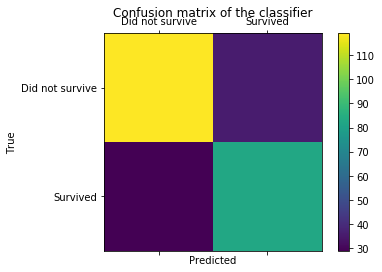

Accuracy: 0.7565543071161048 
Precision: 0.8040540540540541 
Recall: 0.7677419354838709 
F1 score: 0.7854785478547855


(0.7565543071161048,
 0.8040540540540541,
 0.7677419354838709,
 0.7854785478547855)

In [9]:
# Confusion Matrix
pred_y2 = np.argmax(pred_y, axis=1)

labels = ['Did not survive', 'Survived']
cm = sklearn.metrics.confusion_matrix(cross_y, pred_y2)

# Plotting
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

get_metrics(cm, True)

## Past results:

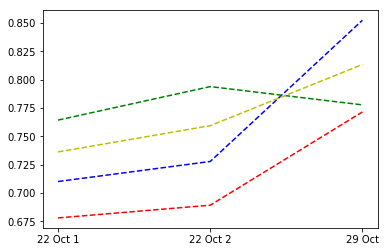

In [10]:
# Past results
data = {'22 Oct 1': [[120, 37], [ 49, 61]],
        '22 Oct 2': [[131, 34], [ 49, 53]],
        '29 Oct'  : [[133, 38], [ 23, 73]]}
names = list(data.keys())
values = list(data.values())

accuracy = [] # ratio of correctly predicted observation to the total observations
precision = [] # ratio of correctly predicted positive observations to the total predicted positive observations
recall = [] # ratio of correctly predicted positive observations to the all observations in actual class - yes
f1score = [] # weighted average of Precision and Recall

for cm in values:
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]
    accuracy.append((TP+TN)/(TP+FP+FN+TN))
    precision.append(TP/(TP+FP))
    recall.append(TP/(TP+FN))
    f1score.append(2/((1/recall[-1])+(1/precision[-1])))
    
#print('Accuracy:', accuracy, '\nPrecision:', precision, '\nRecall:', recall, '\nF1 score:', f1score)

# Plot curves TO
plt.plot(names, accuracy, 'r--', names, precision, 'b--', names, recall, 'g--', names, f1score, 'y--')
plt.show()

In [11]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Female,CabinType,Title,TicketType,TickerNumber
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,0,8,11,1,21171
2,1,1,38.0,1,0,71.2833,1,1,2,12,5,17599
3,1,3,26.0,0,0,7.9250,0,1,8,8,6,3101282
4,1,1,35.0,1,0,53.1000,0,1,2,12,0,113803
5,0,3,35.0,0,0,8.0500,0,0,8,11,0,373450


In [12]:
ticket_type = [ticket.split(" ")[0].split("/")[0].replace(".", "") for ticket in df_original.Ticket]
ticket_list = list(set(ticket_type))
ticket_list.sort()
ticket_list[-24:]


['A',
 'A4',
 'A5',
 'C',
 'CA',
 'FC',
 'FCC',
 'Fa',
 'LINE',
 'P',
 'PC',
 'PP',
 'SC',
 'SCO',
 'SO',
 'SOC',
 'SOP',
 'SOTON',
 'SP',
 'STON',
 'SW',
 'W',
 'WE',
 'WEP']

In [13]:
ticket_type = [ticket.split(" ")[0].split("/")[0].replace(".", "") for ticket in df_original.Ticket]
ticket_list = list(set(ticket_type))
ticket_list.sort()
ticket_list[-24:]

['A',
 'A4',
 'A5',
 'C',
 'CA',
 'FC',
 'FCC',
 'Fa',
 'LINE',
 'P',
 'PC',
 'PP',
 'SC',
 'SCO',
 'SO',
 'SOC',
 'SOP',
 'SOTON',
 'SP',
 'STON',
 'SW',
 'W',
 'WE',
 'WEP']

In [14]:
item = 5

# Average with sex and title
df.loc[6,:]

Survived             0
Pclass               3
Age                  0
SibSp                0
Parch                0
Fare            8.4583
Embarked             2
Female               0
CabinType            8
Title               11
TicketType           0
TickerNumber    330877
Name: 6, dtype: object

In [15]:
df.Female

PassengerId
1      0
2      1
3      1
4      1
5      0
6      0
7      0
8      0
9      1
10     1
11     1
12     1
13     0
14     0
15     1
16     1
17     0
18     0
19     1
20     1
21     0
22     0
23     1
24     0
25     1
26     1
27     0
28     0
29     1
30     0
      ..
862    0
863    1
864    1
865    0
866    1
867    1
868    0
869    0
870    0
871    0
872    1
873    0
874    0
875    1
876    1
877    0
878    0
879    0
880    1
881    1
882    0
883    1
884    0
885    0
886    1
887    0
888    1
889    1
890    0
891    0
Name: Female, Length: 891, dtype: int64

In [16]:
df_original.Ticket

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
5                330877
6                 17463
7                349909
8                347742
9                237736
10              PP 9549
11               113783
12            A/5. 2151
13               347082
14               350406
15               248706
16               382652
17               244373
18               345763
19                 2649
20               239865
21               248698
22               330923
23               113788
24               349909
25               347077
26                 2631
27                19950
28               330959
29               349216
             ...       
861               28134
862               17466
863            CA. 2343
864              233866
865              236852
866       SC/PARIS 2149
867            PC 17590
868              345777
869              347742
870              349248
871             